# ASR Punctuation Restoration Experiments
By Bart Pleiter S4752740 for the course ASR 2021-2022

In [1]:
# imports
import pandas as pd
import numpy as np
import re
import pickle
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import mixed_precision
import tensorflow_addons as tfa
from tensorflow.keras.utils import Sequence

from transformers import BertTokenizer
from transformers import TFBertModel

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# use mixed precision to speed up training on my RTX3050
mixed_precision.set_global_policy('mixed_float16')

memoryLimit = 7000 # 7.0GB

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memoryLimit)])
    except RuntimeError as e:
        print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050, compute capability 8.6


In [3]:
# flags
RECREATE_PICKLE = False # recreate the dataset prepared with the transformer's tokenizer

# hyperparameters
batchSize = 2
numLabels = 4
segmentSize = 32 # MUST be an even number
seqLen = 512
dropout = 0.2
learningRate = 3e-5
epochs = 12
vocabSize = 30522 # of the BERT model
seqShift = 32

# labels
LABEL_NOTHING = 0
LABEL_COMMA = 1
LABEL_PERIOD = 2
LABEL_QUESTION = 3

labelNames = ["O", "COMMA", "PERIOD", "QUESTION"]

# encode the punctuation label as a number
punctEncode = {
    'O': LABEL_NOTHING,
    'COMMA': LABEL_COMMA,
    'PERIOD': LABEL_PERIOD,
    'QUESTION': LABEL_QUESTION
}

# decode the label for printing purposes
punctDecode = {v: k for k, v in punctEncode.items()}

modelName = "bert-base-uncased"

dataPath = "Data/"

# tokenizer that was used to train the pre-trained transformer model
tokenizer = BertTokenizer.from_pretrained(modelName, do_lower_case=True)

In [4]:
if RECREATE_PICKLE:
    # loading data
    with open(dataPath + 'train_texts.txt', 'r', encoding='utf-8') as f:
        train_text = f.readlines()
    with open(dataPath + 'dev_texts.txt', 'r', encoding='utf-8') as f:
        valid_text = f.readlines()
    with open(dataPath + 'test_texts_2012.txt', 'r', encoding='utf-8') as f:
        test_text = f.readlines()

    # put all datasets together for easy batch operations
    datasets = train_text, valid_text, test_text

In [5]:
# prepare data for the model

def clean_text(text):
    text = text.replace('!', '.')
    text = text.replace(':', ',')
    text = text.replace('--', ',')
    
    reg = "(?<=[a-zA-Z])-(?=[a-zA-Z]{2,})"
    r = re.compile(reg, re.DOTALL)
    text = r.sub(' ', text)
    
    text = re.sub(r'\s-\s', ' , ', text)
    
#     text = text.replace('-', ',')
    text = text.replace(';', '.')
    text = text.replace(' ,', ',')
    text = text.replace('♫', '')
    text = text.replace('...', '')
    text = text.replace('.\"', ',')
    text = text.replace('"', ',')

    text = re.sub(r'--\s?--', '', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = re.sub(r',\s?,', ',', text)
    text = re.sub(r',\s?\.', '.', text)
    text = re.sub(r'\?\s?\.', '?', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = re.sub(r'\s+\?', '?', text)
    text = re.sub(r'\s+,', ',', text)
    text = re.sub(r'\.[\s+\.]+', '. ', text)
    text = re.sub(r'\s+\.', '.', text)
    
    return text.strip().lower()

target_token2id = {t: tokenizer.encode(t)[-2] for t in ".?,"}

target_ids = list(target_token2id.values())
target_ids

id2target = {
    0: 0,
    -1: -1,
}
for i, ti in enumerate(target_ids):
    id2target[ti] = i+1

def create_target(text):
    encoded_words, targets = [], []
    
    words = text.split(' ')

    for word in words:
        target = 0
        for target_token, target_id in target_token2id.items():
            if word.endswith(target_token):
                word = word.rstrip(target_token)
                target = id2target[target_id]

        encoded_word = tokenizer.encode(word, add_special_tokens=False)
        
        for w in encoded_word:
            encoded_words.append(w)
        for _ in range(len(encoded_word)-1):
            targets.append(-1)
        targets.append(target)
        
        #print([tokenizer._convert_id_to_token(ew) for ew in encoded_word], target)
        assert(len(encoded_word)>0)

    encoded_words = [tokenizer.cls_token_id or tokenizer.bos_token_id] +\
                    encoded_words +\
                    [tokenizer.sep_token_id or tokenizer.eos_token_id]
    targets = [-1] + targets + [-1]
    
    return encoded_words, targets

In [6]:
if RECREATE_PICKLE:
    # clean the special characters from the texts
    datasets = [[clean_text(text) for text in ds] for ds in datasets]

    # encode the texts and generate labels
    encoded_texts, targets = [], []

    for ds in datasets:
        x = list(zip(*(create_target(ts) for ts in tqdm(ds))))
        encoded_texts.append(x[0])
        targets.append(x[1])

    print(encoded_texts[1][0][:10])
    print(targets[1][0][:10])

    # make folder for prepared dataset for specific BERT model
    os.makedirs(dataPath + modelName, exist_ok=True)

    # store
    for i, name in enumerate(('train', 'valid', 'test')):
        with open(dataPath + f'{modelName}/{name}_data.pkl', 'wb') as f:
            pickle.dump((encoded_texts[i], targets[i]), f)

In [7]:
# read the processed dataset from file
def getPreparedDataset(prefix):
    with open(dataPath + modelName + "/" + prefix + "_data.pkl", 'rb') as f:
        texts, targets = pickle.load(f)
        X = [word for t in texts for word in t]
        Y = [t for ts in targets for t in ts]
    return X, Y

valX, valY = getPreparedDataset("valid")


In [8]:
class Generator(Sequence):
    
    def __init__(self, X, Y, isTrain=False):
        self.encoded_texts = np.array(X)
        self.targets = np.array(Y)
        self.isTrain = isTrain
        self.indexs = np.arange(len(X))
    
    def __len__(self):
        return len(self.encoded_texts)//seqLen - 1

    def __getitem__(self, index):
        #shift = np.random.randint(seqShift) - seqShift // 2\
        #    if self.isTrain else 0

        start_idx = index * seqLen# + shift
        start_idx = max(0, start_idx)
        end_idx = start_idx + seqLen
        return self.encoded_texts[start_idx: end_idx], self.targets[start_idx: end_idx]

    
train_gen = Generator(valX, valY, isTrain=True)
myit = iter(train_gen)

X1 = []
X2 = []
X3 = []
Y1 = []

for i in range(10):
    a, b = next(myit)
    X1.append(a)
    X2.append([1] * seqLen)
    X3.append([0] * seqLen)

#train_data = train_data.shuffle(shuffle_buffer_size)
#train_data = train_data.batch(batch_size)

# print(train_gen)

# test
#X, y = next(iter(train_data))
#print(X[0].numpy())

#print(tokenizer.decode(X[0].numpy()))
#print()
#print(tokenizer.decode(X[1].numpy()))
#print()
#print(tokenizer.decode(X[2].numpy()))
#print()
#print(tokenizer.decode(X[3].numpy()))

In [9]:
# text preprocessing demo
if False:
    s = "Tyranosaurus: kill me? Not enough, -- said the co-pilot -- ..."
    s = clean_text(s)
    X, Y = encodeRawText(s)
    data, targets = create_target(s)
    print(X)
    print(Y)
    print(data)
    print(targets)
    print([tokenizer._convert_id_to_token(d) for d in data[1:-1]])

In [21]:
# model construction
#bert_input = tf.keras.Input(shape=(seqLen), dtype='int32', name='bert_input')
input_word_ids = tf.keras.Input(shape=(seqLen,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.Input(shape=(seqLen,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.Input(shape=(seqLen,), dtype=tf.int32, name="segment_ids")

module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

#x = TFBertModel.from_pretrained("bert-base-uncased")([input_word_ids, input_mask, segment_ids])[0]
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
clf_output = sequence_output[:, 0, :]
    
x = tf.keras.layers.Dropout(dropout, name="dropout1")(clf_output)
x = tf.keras.layers.Dense(1568, name='linear1')(x)
x = tf.keras.layers.Dropout(dropout, name="dropout2")(x)
x = tf.keras.layers.Activation('relu', name='relu')(x)
x = tf.keras.layers.Dense(len(punctEncode), name='linear2')(x)
model_out = tf.keras.layers.Activation('softmax', dtype='float32', name='softmax')(x)

model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=model_out, name='model')

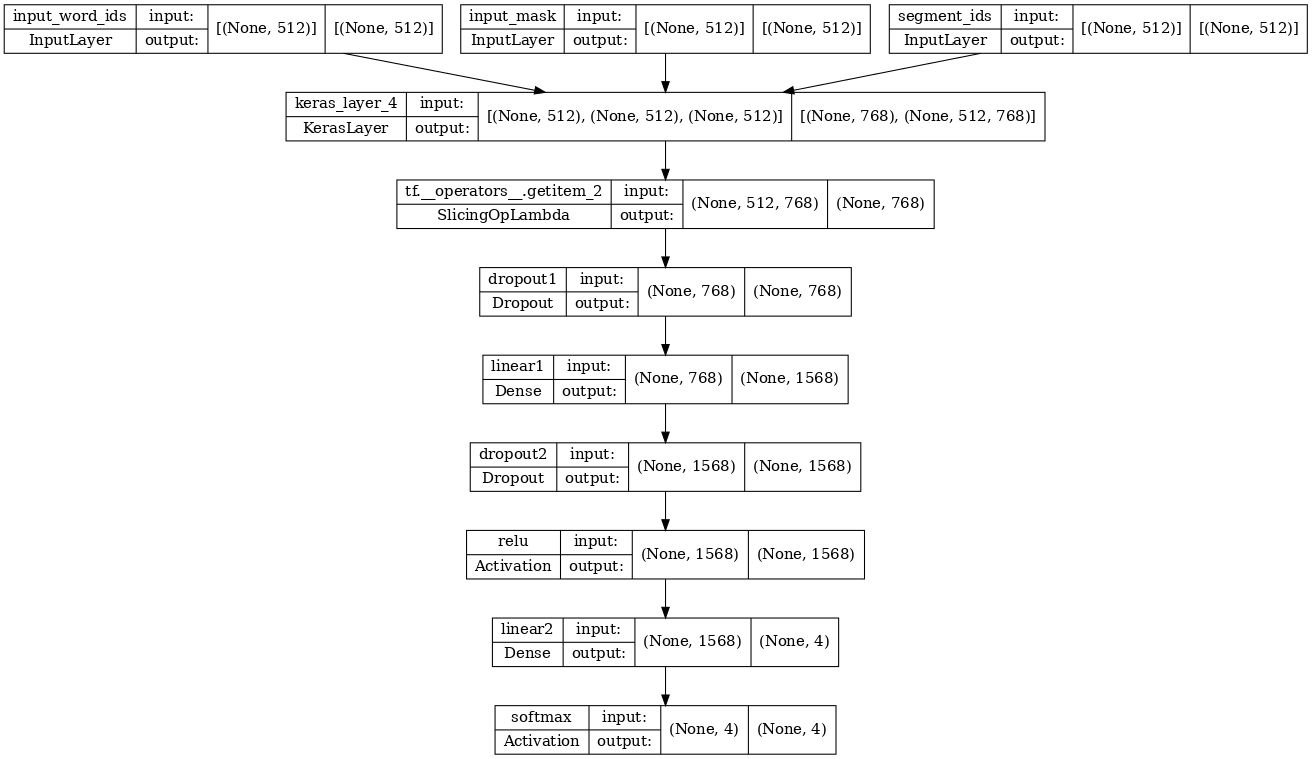

In [22]:
# plot the model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

In [12]:
# evaluates the predicted results
def evaluateResults(Ytrue, Ypred):    
    print(classification_report(Ytrue, Ypred, target_names=labelNames))
    
    confusionMatrix = confusion_matrix(Ytrue, Ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=labelNames)
    print("Confusion matrix:")
    disp.plot()
    plt.show()

In [25]:
# compile the network
#model.compile(
#    optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
#)

model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fb8d43ec1f0>>

In [29]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(4, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [30]:
model = build_model(bert_layer, max_len=512)
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fb6c43707c0>>

In [32]:
# training the data
history = model.fit(
    [np.array(X1), np.array(X2), np.array(X3)], Y1,
    validation_split=0.2,
    epochs=epochs,
    batch_size=32
    #validation_data=(Xval, Yval)
)

Epoch 1/12


ValueError: in user code:

    File "/home/bart/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/bart/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bart/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/bart/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 861, in train_step
        self._validate_target_and_loss(y, loss)
    File "/home/bart/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 827, in _validate_target_and_loss
        raise ValueError(

    ValueError: No loss found. You may have forgotten to provide a `loss` argument in the `compile()` method.


In [ ]:
# show the fitting history
history.history

# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Validation set

In [ ]:
# generate output on validation data
valPredict = model.predict(Xval)

# select best class for each token
resultYval = valPredict.argmax(axis=1)

In [ ]:
evaluateResults(Yval, resultYval)

# Test set

In [ ]:
# loading the data for testing
Xtest, Ytest, testTokens = loadDataFromTEDtalkDataset("IWSLT2012data/test2011", tokenizer)
Xtestasr, Ytestasr, testasrTokens = loadDataFromTEDtalkDataset("IWSLT2012data/test2011asr", tokenizer)

In [ ]:
# generate output on test data
testPredict = model.predict(Xtest)
testPredictasr = model.predict(Xtestasr)

# select best class for each token
resultYtest = testPredict.argmax(axis=1)
resultYtestasr = testPredictasr.argmax(axis=1)

In [ ]:
print("Test set:")
evaluateResults(Ytest, resultYtest)

print("Test ASR set:")
evaluateResults(Ytestasr, resultYtestasr)

In [ ]:
# evaluate on test data
#resultsTest = model.evaluate(Xtest, Ytest, batch_size=batchSize)
#print("test loss, test acc:", resultsTest)

#resultsTestasr = model.evaluate(Xtest, Ytest, batch_size=batchSize)
#print("test (asr) loss, test (asr) acc:", resultsTest)

In [ ]:
# show the restoration on the test sets
# get results
#restoreTest = model.predict(Xtest)
#restoreTestasr = model.predict(Xtestasr)

# select best class for each token
#resultYtest = restoreTest.argmax(axis=1)
#resultYtestasr = restoreTestasr.argmax(axis=1)

# reconstruct text with predicted tokens
#resTextTest = reconstructText(testTokens, resultYtest, tokenizer)
#resTextTestasr = reconstructText(testasrTokens, resultYtestasr, tokenizer)

In [ ]:
#print(resTextTest)

In [ ]:
#print(resTextTestasr)

In [ ]:
# example restoration on paragraph from a story
#toPredict = "Then he sat down and began to reflect. In the morning he must find seconds. Whom should he choose? He searched his mind for the most important and celebrated names of his acquaintance. At last he decided on the Marquis de la Tour-Noire and Colonel Bourdin, an aristocrat and a soldier; they would do excellently. Their names would look well in the papers. He realised that he was thirsty, and drank three glasses of water one after the other; then he began to walk up and down again. He felt full of energy. If he played the gallant, showed himself determined, insisted on the most strict and dangerous arrangements, demanded a serious duel, a thoroughly serious duel, a positively terrible duel, his adversary would probably retire an apologist."
#predictText(toPredict, model, tokenizer)

In [ ]:


def insertTarget(x, segment_size):
    # creates segments of surrounding words for each word in x.
    # inserts a zero token ([PAD]) halfway the segment, right after the inserted token.
    # for the first segmentSize/2 tokens, the end of the data is used, as if the text loops
    X = []
    x_pad = x[-((segment_size-1)//2-1):]+x+x[:segment_size//2]

    for i in range(len(x_pad)-segment_size+2):
        segment = x_pad[i:i+segment_size-1]
        segment.insert((segment_size-1)//2, 0)
        X.append(segment)

    return np.array(X)

def encodeRawText(text):
    # splits the text on spaces and creates labels for each created token
    # the resulting token list will have no punctuation anymore
    splitOnSpace = text.split(' ')
    X = []
    Y = []
    
    for word in splitOnSpace:
        if len(word) > 0: # skip empty tokens
            # look for tokens at the end of the word
            # remove if found when appending to X
            # also make everything lowercase
            if word[-1] == '.':
                X.append(word.lower()[:-1])
                Y.append(LABEL_PERIOD)
            elif word[-1] == ',':
                X.append(word.lower()[:-1])
                Y.append(LABEL_COMMA)
            elif word[-1] == '?':
                X.append(word.lower()[:-1])
                Y.append(LABEL_QUESTION)
            else:
                X.append(word.lower())
                Y.append(LABEL_NOTHING)
                
    return X, Y

def prepareDataForModel(words, labels, tokenizer):
    # returns a list of segments of token IDs for X
    #  and a list of label tokens for y, corresponding to the segment in X
    #  and a list of the unsegmented token IDs, for easier reconstruction
    X = []
    Y = []
    for word, label in zip(words, labels):
        y = [label]
        # retokenize x
        x = tokenizer.wordpiece_tokenizer.tokenize(word)
        # encode x
        x = tokenizer.convert_tokens_to_ids(x)

        # do not add if tokenize failed
        if len(x) > 0:
            # if multiple tokens, create multiple labels of 0
            #  set the last one to the real label
            if len(x) > 1:
                y = (len(x)-1)*[0]+y
            X += x
            Y += y
                
    # create segments for X, and return together with Y, and the unsegmented tokens
    # return as Numpy array
    return np.array(insertTarget(X, segmentSize)), np.array(Y), X

def getTokenFromSegment(segment):
    # is always at the same place of the segment (assumes even numbers!)
    return segment[segmentSize//2-2]

def reconstructText(tokenList, labels, tokenizer):
    # reconstructs text by detokenizing and applying the given labels
    tokens = tokenizer.convert_ids_to_tokens(tokenList)
    
    reconstructedText = ""
    for tok, label in zip(tokens, labels):
        # no space in between if second token starts with '##'
        if tok.startswith("##"):
            reconstructedText += tok[2:]
        else:
            reconstructedText += " " + tok
        
        # add the punctuation from the label
        if label == LABEL_COMMA:
            reconstructedText += ","
        elif label == LABEL_PERIOD:
            reconstructedText += "."
        elif label == LABEL_QUESTION:
            reconstructedText += "?"
                
    reconstructedText = reconstructedText[1:] # skip the first space
    
    return reconstructedText
    
def loadDataFromFile(path):
    # creates a dataset from a text file, which can be used on the model
    # returns a list of segments of token IDs for X
    #  and a list of label tokens for y, corresponding to the segment in X
    #  and a list of the unsegmented token IDs, for easier reconstruction
    text = ""
    with open(path, 'r') as file:
        text = file.read()
        
    X, Y = encodeRawText(text)
    dataX, dataY, dataTokens = prepareDataForModel(X, Y, tokenizer)
    
    return dataX, dataY, dataTokens

def loadDataFromTEDtalkDataset(path, tokenizer):
    # loads the data from the TED talk dataset, which is already pre-processed
    # returns a list of segments of token IDs for X
    #  and a list of label tokens for y, corresponding to the segment in X
    #  and a list of the unsegmented token IDs, for easier reconstruction
    X = []
    Y = []
    with open(path, "rb") as file:
        for line in file:
            # dataset uses \r\n for newlines
            word, punc = line.decode('utf-8', errors='ignore').replace('\r\n', '').split('\t')
            # encode y
            y = [punctEncode[punc]]
            # retokenize x
            x = tokenizer.wordpiece_tokenizer.tokenize(word)
            # encode x
            x = tokenizer.convert_tokens_to_ids(x)
            
            # do not add if tokenize failed
            if len(x) > 0:
                # if multiple tokens, create multiple labels of 0
                #  set the last one to the real label
                if len(x) > 1:
                    y = (len(x)-1)*[0]+y
                X += x
                Y += y
                
    # create segments for X, and return together with Y, and the unsegmented tokens
    # return as Numpy array
    return np.array(insertTarget(X, segmentSize)), np.array(Y), X

def predictText(text, model, tokenizer):
    # predicts the punctuation for a given text and print the resulting text
    
    # pre-process
    X, Y = encodeRawText(text)
    dataX, dataY, dataTokens = prepareDataForModel(X, Y, tokenizer)
    
    # get results
    results = model.predict(dataX)
    
    # select best class for each token
    resultY = results.argmax(axis=1)
    
    # reconstruct text with predicted tokens
    resText = reconstructText(dataTokens, resultY, tokenizer)
    
    print(resText)